## Suffering niggas

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import bokeh.plotting
import catboost
import sklearn.preprocessing, sklearn.feature_selection, sklearn.model_selection
from sklearn.pipeline import Pipeline, make_pipeline
import sklearn.base
from sklearn.base import BaseEstimator, TransformerMixin
import seaborn as sns
import dateutil.parser
import collections
import sklearn.utils
import itertools
import re

import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

SEED = 42
np.random.seed = SEED

%matplotlib inline

<IPython.core.display.Javascript object>

In [2]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')

In [3]:
display(
    X_train.shape,
    X_train.columns,
    X_train.isnull().sum()[X_train.isnull().sum() > 0],
)

(59400, 40)

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')

funder                3635
installer             3655
subvillage             371
public_meeting        3334
scheme_management     3877
scheme_name          28166
permit                3056
dtype: int64

In [4]:
pd.Series({c: ([X_train[c].dtype] + list(X_train[c].unique()[:4])).__repr__() for c in X_train.columns})

amount_tsh                     [dtype('float64'), 6000.0, 0.0, 25.0, 20.0]
basin                    [dtype('O'), 'Lake Nyasa', 'Lake Victoria', 'P...
construction_year                 [dtype('int64'), 1999, 2010, 2009, 1986]
date_recorded            [dtype('O'), '2011-03-14', '2013-03-06', '2013...
district_code                                [dtype('int64'), 5, 2, 4, 63]
extraction_type          [dtype('O'), 'gravity', 'submersible', 'swn 80...
extraction_type_class    [dtype('O'), 'gravity', 'submersible', 'handpu...
extraction_type_group    [dtype('O'), 'gravity', 'submersible', 'swn 80...
funder                   [dtype('O'), 'Roman', 'Grumeti', 'Lottery Club...
gps_height                          [dtype('int64'), 1390, 1399, 686, 263]
id                             [dtype('int64'), 69572, 8776, 34310, 67743]
installer                [dtype('O'), 'Roman', 'GRUMETI', 'World vision...
latitude                 [dtype('float64'), -9.8563217699999992, -2.147...
lga                      

In [5]:
y_train.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [6]:
def show_intersections(A, B, add_cat_feats=['date_recorded', 'construction_year',
                                            'date_recorded_year', 'date_recorded_month']):
    cat_features = np.where(np.array([(X_train[c].dtype == object)
                                  or (c.endswith('code'))
                                  or (c in add_cat_feats) for c in X_train.columns.values]))[0]
    cat_feats_observed = []
    for c in cat_features:
        n_uni = len(set(A.iloc[:,c]).union(B.iloc[:,c]))
        n_int = len(set(A.iloc[:,c]).intersection(B.iloc[:,c]))
        n_te = len(set(A.iloc[:,c]))
        cat_feats_observed.append((A.columns[c], n_int/n_uni, n_int/n_te))
    cat_feats_observed = (
        pd.DataFrame(cat_feats_observed, columns=['var', 'intersection/union', 'intersection/B'])
        .sort_values('intersection/B')
    )
    return cat_feats_observed
show_intersections(X_train, X_test)

,var,intersection/union,intersection/B
3,wpt_name,0.055950,0.068342
5,subvillage,0.294315,0.326939
2,installer,0.343011,0.385368
1,funder,0.344699,0.388830
14,scheme_name,0.563960,0.599926
0,date_recorded,0.861789,0.893258
13,scheme_management,0.923077,0.923077
10,ward,0.930887,0.933556
17,extraction_type,0.944444,0.944444
7,region_code,0.962963,0.962963


In [7]:
from sklearn.model_selection import train_test_split

In [8]:
class HideMissingValues(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        for c in X.columns:
            if np.issubdtype(X[c].dtype, np.number):
                X.loc[:,c].fillna(X.loc[:,c].median(), inplace=True)
            else:
                X.loc[:,c].fillna('Unknown', inplace=True)
                X.loc[:,c] = X[c].map(lambda x: str(x))
        return X
    
    
class DropGarbage(BaseEstimator, TransformerMixin):
    def __init__(self, cols=['id', 'funder', 'recorded_by', 'date_recorded']):
        self.cols = cols
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(self.cols, axis=1, errors='ignore')

class SplitDate(BaseEstimator, TransformerMixin):
    def __init__(self, col):
        self.col = col
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        def t(x):
            if isinstance(x, str):
                x = dateutil.parser.parse(x)
            return (x.year, x.month, x.day, x.weekday())
        X = X.copy()
        (X.loc[:, self.col + '_year'],
         X.loc[:, self.col + '_month'],
         X.loc[:, self.col + '_day'],
         X.loc[:, self.col + '_weekday']) = zip(
        *X.loc[:, self.col].map(t))
        return X

    
class HandyFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X.loc[:,'amount_per_man'] = X.loc[:,'amount_tsh']/X.loc[:,'population']
        return X

class OutcomeFrequences(BaseException, TransformerMixin):
    def __init__(self, groupby, drop=False):
        self.groupby = groupby
        self.drop = drop
        self.cnts_ = None
        self.fq_cols_ = None
        self.unknowns_ = 0
        
    def fit(self, X, y=None):
        possible_outcomes = [_.split()[-1] if isinstance(_, str) else _ for _ in np.unique(y)]
        n_outs = len(possible_outcomes)
        self.cnts_ = collections.defaultdict(lambda: np.zeros(n_outs))
        # print(self.groupby)
        igroupby = np.array([X.columns.get_loc(_) for _ in self.groupby])
        for i in range(X.shape[0]):
            # assuming $y$ is label-encoded
            keys, out = tuple(X.iloc[i, igroupby].values), y[i]
            self.cnts_[keys][out] += 1 # no of `(keys, out)` occurences
        for k in self.cnts_:
            self.cnts_[k] //= self.cnts_[k].sum()
            
        self.possible_outcomes_ = possible_outcomes
        self.fq_cols_ = ['_'.join(self.groupby + [str(out), 'fq'],) for out in possible_outcomes]
        return self
    
    def transform(self, X):
        self.unknowns_ = 0
        igroupby = np.array([X.columns.get_loc(_) for _ in self.groupby])
        new_cols = [tuple([None for out in self.possible_outcomes_]) for _ in range(X.shape[0])]
        for i in range(X.shape[0]):
            keys = tuple(X.iloc[i, igroupby].values)
            if keys in self.cnts_:
                new_cols[i] = tuple([self.cnts_[keys][out] for out in self.possible_outcomes_])
            else:
                self.unknowns_ += 1
        self.unknowns_ /= X.size
        # print(str(X)[:100])
        # print(str(new_cols)[:100])
        # print(str(self.fq_cols_[:100]))
        new_cols = pd.DataFrame(new_cols, columns=self.fq_cols_)
        for c in self.fq_cols_:
            new_cols.loc[:,c].fillna(0, inplace=True) # new_cols.loc[:,c].median(), inplace=True)
        X = pd.concat((X, new_cols,), axis=1)
        if self.drop:
            X.drop(self.groupby, axis=1, inplace=True, errors='ignore')
        return X

class ExplicitAge(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X.loc[:, 'age'] = X.loc[:,'date_recorded_year'] - X.loc[:,'construction_year']
        return X

In [9]:
def split_train_cv_test(X, y, proportions=(.75, .25/2, .25/2)):
    # expecting $y$ to be numpy array
    outs = np.unique(y)
    proportions = np.array(proportions)
    classes = [np.where(y == i)[0] for i in outs]
    xparts = [[] for _ in proportions]
    yparts = [[] for _ in proportions]
    for cidx in classes:
        cidx = sklearn.utils.shuffle(cidx)
        cprops = cidx.size * proportions
        cprops = cprops.astype(int)
        cprops[-1] = cidx.size - cprops[:-1].sum()
        cx = X.iloc[cidx,:]
        cy = y[cidx]
        for xpart, ypart, sz in zip(xparts, yparts, cprops):
            xpart.append(cx.iloc[:sz,:])
            ypart.append(cy[:sz])
            cx, cy = cx.iloc[sz:,:], cy[sz:]
    xparts = [pd.concat(xpart) for xpart in xparts]
    yparts = [np.concatenate(ypart) for ypart in yparts]
    # parts = []
    # print(len(xparts), 'parts')
    # for xpart, ypart in zip(xparts, yparts):
    #     parts.append(xpart)
    #     parts.append(ypart)
    parts = xparts + yparts
    return parts

/home/god/py/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


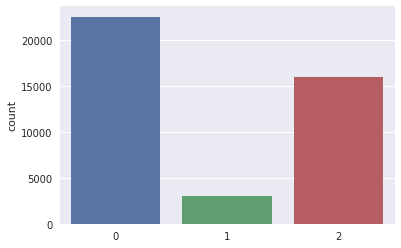

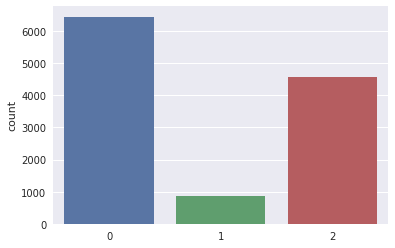

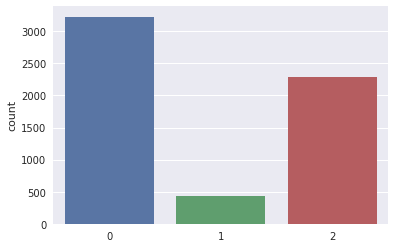

In [10]:
prepr = Pipeline([
    ('fillna', HideMissingValues()),
    ('date_recorded', SplitDate('date_recorded')),
    ('handyfeats', HandyFeatures()),
    ('age', ExplicitAge()),
] + [
    ('_'.join(catcol) + '_fq', OutcomeFrequences(catcol, drop=False))
    for catcol in [
        ['date_recorded_year', 'date_recorded_month',],
    ]
] + [
    (catcol + '_fq', OutcomeFrequences([catcol], drop=False))
    for catcol in ['basin', 'lga',
                   'extraction_type_class', 'region',
                   'management', 'ward', 'scheme_name', 'region_code', 'extraction_type',
                   'construction_year',
                   'date_recorded_year',
                   'date_recorded_month',]
] + [
    ('drop', DropGarbage(cols=[
        'id', 'recorded_by',
    ]))
])

y_enc = sklearn.preprocessing.LabelEncoder()
y = y_enc.fit_transform(y_train.iloc[:,1])
X = prepr.fit_transform(X_train, y)
X_te = prepr.transform(X_test)
X_tr, X_cv, X_va, y_tr, y_cv, y_va = split_train_cv_test(X, y, proportions=(.7, .2, .1))

sns.countplot(y_tr)
plt.show()
sns.countplot(y_cv)
plt.show()
sns.countplot(y_va)


In [11]:
for fname, ds in [('X_tr.csv', X_tr),
                  ('X_cv.csv', X_cv),
                  ('X_va.csv', X_va),
                  ('y_tr.csv', y_tr),
                  ('y_cv.csv', y_cv),
                  ('y_va.csv', y_va),
                  ('X_te.csv', X_te)]:
    if not isinstance(ds, pd.DataFrame):
        ds = pd.DataFrame(ds, columns=['status_group'])
    ds.to_csv(fname)

In [12]:
pd.Series(y_enc.classes_).to_csv('out_classes.csv')